# Twitter sentiment analysis

Sentiment analysis is used to find nuances in the emotional level attached to specific topics or locations. Those insights can be very useful, and are commonly used to predict stock market time series for example. Twitter is the perfect place from where to get data, as the platform allows user from around the world to express their opinions about any topic. By analysing large numbers of tweets, it is possible to find the overall sentiment attached to the group of tweets. 

### What this notebook is about

The aim of this notebook is to show the means to getting data from tweets and performing sentiment analysis on their contents. The tweets can be parsed by location, time or topic, which can lead to interesting insights on the emotional character of each category.

Twitter provides a REST API which can be used either to listen to the stream of tweets, or to get historical tweets. We are going to look a both ways of getting tweets data.

## Stream listener

In order to get data from the stream of tweets, we need to build a StreamListener class. In the following code we will be using the ```non_retweeted_text``` available in ```main.py``` which returns the content of the tweet provided it is non-retweeted.

In [1]:
import sys
sys.path.append("C:/Users/Maxime/PycharmProjects/")
sys.path.append("C:/Users/Maxime/PycharmProjects/TwitterSentimentAnalysis")
from TwitterSentimentAnalysis.settings import non_retweeted_text

We have to initialize the API object by giving our Twitter API credentials

In [2]:
from TwitterSentimentAnalysis.settings import API_KEY, API_SECRET_KEY, TOKEN, TOKEN_SECRET
import tweepy

auth = tweepy.OAuthHandler(API_KEY, API_SECRET_KEY)
auth.set_access_token(TOKEN, TOKEN_SECRET)
api = tweepy.API(auth)

Then define the ```StreamListener``` class that stores tweet data as they arrive

In [3]:
import json

class StreamListener(tweepy.StreamListener):

    def __init__(self, count):
        super(StreamListener, self).__init__()
        self.count = count
        self.data = []

    def on_data(self, data):
        """
        called when a tweet is received, contained in the 'status' object
        """
        # We want only non-retweeted (original) tweets
        json_data = json.loads(data)
        text = non_retweeted_text(json_data)
        if text is None:
            return  # ignores tweet if retweeted

        print(text)
        self.data.append(text)

        # Stream end criterion: count limit
        if len(self.data) >= self.count:
            return False

    def on_error(self, status_code):
        """
        called on error
        """
        # On error, ignore current tweet
        if status_code == 420:
            return False


def launch_stream(count, query):
    """
    Sets up the stream listener and takes user input for query
    """
    stream_listener = StreamListener(count)
    stream = tweepy.Stream(auth=api.auth, listener=stream_listener, tweet_mode='extended')
    stream.filter(track=query, languages=["en"])
    data = stream_listener.data
    return data

We just have to call the ```launch_stream``` function in order to get twitter data for a given topic

In [ ]:
data = launch_stream(100, ['#EURO2014'])

## Tweets search

Listening to a stream of tweets can be inappropriate if the queries are narrowed and there are only a few tweets per minute being received. The other solution to get tweets data in to search in the historical data.

The REST API also allows us to perform queries in the historical tweets data per topic, language or location. 

One issue is that the maximum tweet count per single query is limited to 100. This means we have to perform multiple queries if we want to go beyond that number. This is made possible by using the ```max_id``` argument, which tells the API to return only the tweets that are __older__ than the tweet of ```id``` equal to ```max_id```, the tweets being sorted by ```id``` historically.

In [4]:
from TwitterSentimentAnalysis.settings import non_retweeted_tweets

def tweets_search(query, language, count):
    nb_queries = int(count/100) + 1
    data = []
    tweets = []
    max_id = None
    while len(data) < count:
        tweet_batch = api.search(q=query, lang=language, count=100, tweet_mode="extended", max_id=max_id)
        try:
            max_id = tweet_batch[-1].id # max_id for the next query is the id of current query's last tweet
            for tweet in tweet_batch:
                tweets.append(tweet)
        except IndexError:
            print('index error')
        # Keep only non-retweeted (newly created) tweets
        retweeted_tweets = non_retweeted_tweets(tweets)

        for tweet in retweeted_tweets:
            text = tweet.full_text
            data.append(text)
    # We print the last id of last query in case we want to pursue querying later
    print('last max_id: ' + str(max_id))

    return data

In [5]:
from datetime import datetime
start = datetime.now()
data =tweets_search(['trump'], 'en', 150)
print(str(datetime.now()-start))

last max_id: 1045696684485947393
0:00:06.621846


With the ```launch_stream``` and ```search``` functions we can now access streaming twitter data. However, this data still needs to be cleaned before doing proper sentiment analysis. First, we can see that a large proportion of the tweets come with links. Those links cannot be taken into account in our sentiment analysis, so we are going to remove them by using the ```remove_url``` function

In [6]:
import regex as re

def remove_url(s):
    s = re.sub(r'http\S+', '', s)
    return s

In [7]:
for i in range(len(data)):
    data[i] = remove_url(data[i])

The same logic goes for nicknames tagging, i.e. strings starting with '@' and mentionning a particular user

In [8]:
def remove_tags(s):
    s = re.sub(r'@\S+', '', s)
    return s

In [9]:
for i in range(len(data)):
    data[i] = remove_tags(data[i])

## Sentiment analysis

There are various techniques to determine the sentiment score of a text. It is possible to use classifiers and train them on some data, or to use methods that doesn't require prior training. Since we are using raw tweets data without attached sentiment score, we cannot train a classifier and hence have to choose training-free methods. 

Among those, we can cite the AFINN, Liu and Hu and VADER methods, which basically basically counts the number of occurences of words and give them sentiment score according to a lexicon. Those methods are not good at predicting the polarity of a single sentence, but are fine if we want to compute averages among a large number of sentences as it is our case.

We are going to use the VADER method, which is implemented in the ```nltk``` library. This method can yield a score for a given input of text. Let's apply the VADER method to all the tweets in our data.

In [10]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

vader = SentimentIntensityAnalyzer()

scores = []
for text in data:
    scores.append(vader.polarity_scores(text))

C:\Users\Maxime\Miniconda3\envs\TradingAlgo\lib\site-packages\nltk\twitter\__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


Then we can compute the mean scores among all the tweets, which give us insights about the overall emotional level of the group of tweets

In [11]:
import pandas as pd

score_df = pd.DataFrame(scores)
score_df.mean()

compound    0.089387
neg         0.083706
neu         0.797157
pos         0.119124
dtype: float64

## Results part

The mean of the polarity scores of a set of tweets can be used to compare different topics, locations or dates emotional levels. Our first plot will be to compare a positive and a negative topic, to show that our method works. 

Let's change the form of our dataframe so that we can plot both positive scores and negative scores distributions on the same plot

In [182]:
df = pd.DataFrame(columns=['score', 'type'])
for i in ['neg','pos']:
    df_temp = pd.DataFrame(score_df[i].copy())
    df_temp.loc[:, 'type'] = i
    df_temp = df_temp.rename(columns={i: 'score'})
    df = pd.concat([df, df_temp], axis=0, sort=True)

Then using ```seaborn```we can plot the distribution of scores using boxplots

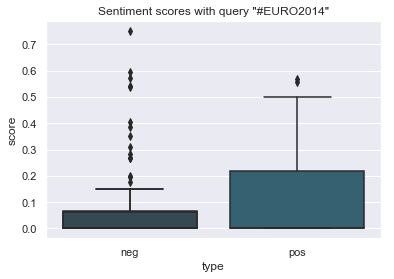

In [135]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="darkgrid")
sns.set_palette("PuBuGn_d")
fig = plt.figure()
plt.title('Sentiment scores with query "#EURO2014"')
sns.boxplot(data=df, y='score', x='type')

"#EURO2014" is obviously a quite positive term, and it turns out that the positive tweets greatly outnumber the negative ones.

Now let's do the same analysis by using a more negative term.
For simplicity, we will be using the ```search``` function from ```main.py``` that reproduce the code shown so far and returns results that can be plotted directly.

In [5]:
from TwitterSentimentAnalysis.main import search

df = search(['trump'], 'en', 1000)

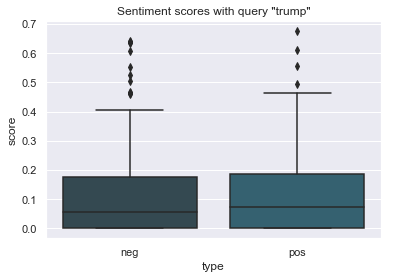

In [11]:
fig = plt.figure()
plt.title('Sentiment scores with query "trump"')
sns.boxplot(data=df, y='score', x='type')

As excpeted, keywords associated to more negative subjects lead to a higher negative scores mean. 

As a more visual example, let's see if we can find nuances between the emotional levels associated to big cities around the world.

For this purpose, data containing the last 5000 original tweets about 55 cities has been downloaded using the code shown in the notebook. Each tweet contain four values: compound, negative score, neutral score and positive score. From that, we can compute two interesting metrics

The first is the polarity of the sentiment, which is the difference between positive scores and negative scores.
The second is the strength of the sentiments, which is the sum of positive and negative scores. Indeed, two cities can have the same polarity score (i.e. same proportion of positive and negative tweets), but one might generate stronger sentiments in both directions while the other might generate more neutral reactions

Let's compute our metrics for every city in the database

In [12]:
cities = ['Paris', 'Berlin', 'London', 'Madrid', 'Barcelona', 'Oslo', 'Atlanta', 'Chicago', 
          'Dallas', 'Delhi', 'Hong Kong', 'Istanbul', 'Kiev', 'Kuala Lumpur', 'Lisboa', 'Moscow',
         'New York City', 'Ottawa', 'Rio de Janeiro', 'Rome', 'Singapore', 'Venice', 'Wien',  'Warsaw', 
          'Zagreb', 'Mexico City', 'Jerusalem', 'Cairo', 'Tunis', 'Algiers', 'Tehran', 'Miami', 'Caracas',
         'Baku', 'Baghdad', 'Astana', 'Nairobi', 'Bangkok', 'Cape Town', 'Lucknow', 'Dublin', 'Tokyo', 
         'Tripoli', 'Vilnius', 'Kathmandu', 'Auckland', 'Muscat', 'Karachi', 'Panama', 'Asuncion', 'Lima', 
         'Manila', 'Doha', 'Bucharest']

cities_info = {}
for city in cities:
    scores = pd.read_csv(city.lower() + '_mean.txt', names=['type', 'score'], header=0).set_index('type')
    polarity = scores.loc['pos', 'score'] - scores.loc['neg', 'score']
    amplitude = scores.loc['pos', 'score'] + scores.loc['neg', 'score']
    cities_info[city] = {'polarity': polarity, 'amplitude': amplitude}

For visualization purposes, we are going to draw a map of those scores using ```folium```. Each city in going to be placed on the map as dots. The polarity score will be represented as a variation in the color, while the amplitude score will be the radius of the dot.

For that we need to access the coordinates of each city. Those are stored in the ```cities_coordinates.txt``` file. Let's add those coordinates informations to our ```cities_info``` dictionnary

In [13]:
coordinates = pd.read_csv('cities_coordinates.csv', sep=';', names=['id', 'country', 'city', 'longitude', 'latitude', 'altitude'])

In [14]:
for city, value in cities_info.items():
    longitude = coordinates[coordinates['city'] == city].loc[:, 'longitude'].item()
    latitude = coordinates[coordinates['city'] == city].loc[:, 'latitude'].item()
    value['longitude'] = longitude
    value['latitude'] = latitude

The dict object is converted into a dataframe for ease of manipulation

In [15]:
cities_info = pd.DataFrame(cities_info).transpose()

In order for our dots to change color as their polarity varies, we must define a colormap and assign a color value to each city.

In [16]:
from pylab import *
import numpy as np
import matplotlib.pyplot as plt

nb_classes = 10 # number of different colors

min_pol = min(cities_info['polarity'])
max_pol = max(cities_info['polarity'])
color_classes = np.linspace(min_pol, max_pol, nb_classes) # polarity ranges for each color
color_classes = np.flip(color_classes, axis=0)

cmap = cm.get_cmap('coolwarm', nb_classes) # colormap object which returns 'nb_classes' colors of a given color range

cities_info['color'] = 0 # We add a ' color' column that will receive color codes for each city

# Assign color codes for each city
for i in range(len(color_classes) - 1):
    mask1 = cities_info['polarity'] <= color_classes[i]
    mask2 = cities_info['polarity'] >= color_classes[i + 1]
    mask = mask1 & mask2
    rgb = cmap(i)[:3]
    hex_ = matplotlib.colors.rgb2hex(rgb)
    cities_info.loc[mask, 'color'] = hex_


We can now create the map

In [18]:
import folium

folium_map = folium.Map(location=[0, 0],
                        zoom_start=2,
                        tiles="CartoDB dark_matter")

for row in cities_info.iterrows(): # For every city, create a dot with position, color and radius informations
    
    marker = folium.CircleMarker(location=[row[1]['longitude'], row[1]['latitude']], fill=True, popup=row[0] + ": polarity %.2f" % row[1]['polarity'] + ", amplitude %.2f" % row[1]['amplitude'] , 
                                 color=row[1]['color'], radius=row[1]['amplitude']*50)
    marker.add_to(folium_map)
display(folium_map)
folium_map.save("map.html")

![alt text](map.png "Title")

The following map is a screenshot of the actual zoomable map with annotations. To get the full map,  open this document in Jupyter or refer to the ```map.html``` file provided in the repository.

There are a few things to comment on these results. First, data for each city is comprised of the last 5000 tweets as of 28/09/2018, 10:30 AM. This means that the time window on which the tweets were collected goes until the day before at most. Thus, those emotional scores are specific to this date, and might be different at other timestamps. 

Second, for the sake of simplicity in the sentiment analysis, only tweets wrote in english were recorded. Thus the scores reflect a view of the english-word toward those cities, and might change if we switched to the local language for each city.

It turns out that only a few cities have a very low polarity.

## Conslusion

NLP methods such as VADER are useful to quickly get informations about emotional trends in a set of texts. 
However, it is possible to greatly improve the accuracy of the model. Tweet data is different from sentences we can find in books, which often are the basis for lexicons used by methods like VADER. People use a lot of argot words which are not necessarely catched by VADER but can prove to be very useful. Moreover, taking emojis into account can be a great step forward as emojis are designed to express the emotional level of a sentence. Having access to a training dataset involving tweet data and using a NLP classifier could also lead to significant improvements.